# View Histogram Data Of Car and Non-Car image to understand HOG better

In [1]:
import cv2 as cv

In [2]:
def concatPathAndFilename(path, filename):
    return path + '/' + filename

In [3]:
vehicle = 'CarTrainingData/vehicles/KITTI_extracted'
non_vehicle = 'CarTrainingData/non-vehicles/GTI'

vehicle_img = cv.imread(concatPathAndFilename(vehicle, '1.png'))
grey_vehicle_img = cv.cvtColor(vehicle_img, cv.COLOR_BGR2GRAY)
non_vehicle = cv.imread(concatPathAndFilename(non_vehicle, 'image5.png'))
grey_non_vehicle = cv.cvtColor(non_vehicle, cv.COLOR_BGR2GRAY)

In [4]:
img_size = vehicle_img.shape[:2]
img_size # H x W

(64, 64)

In [5]:
from skimage.feature import hog

hog_desc, hog_image = hog(vehicle_img, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True, channel_axis=-1)
hog_desc_nv, hog_image_nv = hog(non_vehicle, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True, channel_axis=-1)

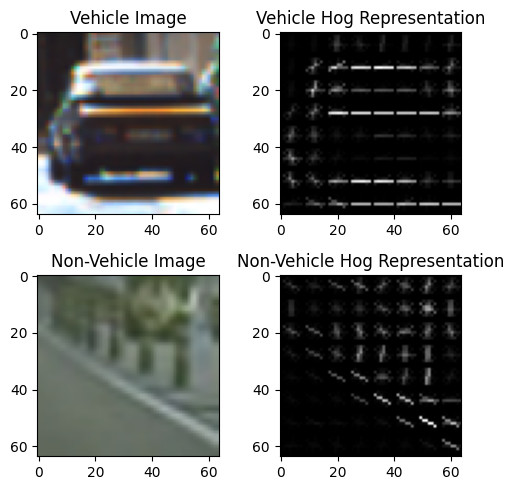

In [6]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(nrows = 2, ncols = 2, figsize=(5,5))
axis[0, 0].imshow(vehicle_img)
axis[0, 0].set_title("Vehicle Image")
axis[0, 1].imshow(hog_image, cmap='grey')
axis[0, 1].set_title("Vehicle Hog Representation")
axis[1, 0].imshow(non_vehicle)
axis[1, 0].set_title("Non-Vehicle Image")
axis[1, 1].imshow(hog_image_nv, cmap='grey')
axis[1, 1].set_title("Non-Vehicle Hog Representation")
plt.tight_layout()
plt.show()

In [7]:
print(hog_desc.shape)
print(hog_desc_nv.shape)

(1764,)
(1764,)


# Get an SVM classifer trained on all the vehicle and non-vehicle training data.

In [8]:
import os
import numpy as np

def getHogFeatures(images):
    features = []
    for im in images:
        hog_desc = hog(im, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=False, channel_axis=-1)
        features.append(hog_desc)
    return features

In [9]:
def getAllImagesInDirectory(dir):
    return [cv.imread(os.path.join(root_dir, file)) for root_dir, _, files in os.walk(dir) for file in files if file.endswith(('.jpg', '.png'))]


In [10]:
vehicle_images = getAllImagesInDirectory('CarTrainingData/vehicles')
non_vehicle_images = getAllImagesInDirectory('CarTrainingData/non-vehicles')
print(np.array(vehicle_images).shape)
print(np.array(non_vehicle_images).shape)

(8792, 64, 64, 3)
(8968, 64, 64, 3)


In [11]:
positive_features = getHogFeatures(vehicle_images)
negative_features = getHogFeatures(non_vehicle_images)
print(np.array(positive_features).shape)
print(np.array(negative_features).shape)

(8792, 1764)
(8968, 1764)


In [12]:
positive_labels = np.ones(len(positive_features))
negative_labels = np.zeros(len(negative_features))

In [13]:
all_features = np.array(positive_features + negative_features)
all_labels = np.concatenate((positive_labels, negative_labels))

In [14]:
print(all_features.shape)
print(all_labels.shape)

(17760, 1764)
(17760,)


In [15]:
# Split my data into train, test and verification
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(all_features, all_labels, test_size=0.2, random_state=9)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=9)

In [16]:
# train model
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Find best parameters
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}  
grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=5)  # cv=5 for 5-fold cross-validation
grid_search.fit(X_train, y_train)  

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(best_params)

{'C': 10, 'kernel': 'rbf'}


In [17]:
# Test Functionality Of Model
from sklearn.metrics import accuracy_score, classification_report  # Add more as needed

y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Accuracy: 0.9912725225225225
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1806
         1.0       1.00      0.99      0.99      1746

    accuracy                           0.99      3552
   macro avg       0.99      0.99      0.99      3552
weighted avg       0.99      0.99      0.99      3552



In [18]:
# Test Functionality With Validation Data (Check Overfitting)
from sklearn.metrics import accuracy_score, classification_report  # Add more as needed

y_pred = best_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)
report = classification_report(y_val, y_pred)
print("Classification Report:\n", report)

Accuracy: 0.9929617117117117
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1759
         1.0       1.00      0.99      0.99      1793

    accuracy                           0.99      3552
   macro avg       0.99      0.99      0.99      3552
weighted avg       0.99      0.99      0.99      3552



In [19]:
# Save model
import pickle

# Save the model
with open('car_detect_svm.pkl', 'wb') as f:
    pickle.dump(best_model, f)

## Model is has an accuracy of 99% at detecting a car. Now time to move to applying this using the sliding window to find where on the image a car is

In [30]:
def slidingWindows(image, window_size=(64, 64), step_size=16):
    img_w = image.shape[1]
    img_h = image.shape[0]
    window_w = window_size[0]
    window_h = window_size[1]
    # Loop through the image starting from the top left and go to the bottom right
    for y in range(0, img_h - window_h + 1, step_size):
        for x in range(0, img_w - window_w + 1, step_size):
            # Now we are looking at the window where the top left pixel is at x and y.
            # The window will go to the right window_w and will go down window_h.
            # recording the window with yield
            yield(x, y, x+window_w, y+window_h)

(720, 1280, 3)
(64, 64, 3)
(1, 1764)


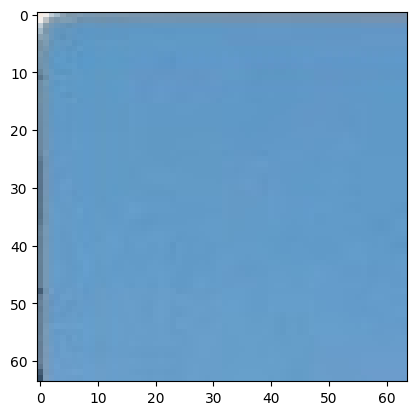

In [31]:
test2 = cv.imread('CarTrainingData/testImages/test1.jpg')
print(test2.shape)
test2 = cv.cvtColor(test2, cv.COLOR_BGR2RGB)
test2 = test2[0:64, 0:64, :]
print(test2.shape)
window_hog_features = np.array(getHogFeatures([test2]))
print(window_hog_features.shape)
plt.imshow(test2[0:64, 0:64, :])
plt.show()


0.9999977851340087
0.95038568930516
0.9087138961120513
0.9093534759182162
0.9450949469010091
0.9774684323172701
0.9272199938512714
0.9489138110274203
0.9399166369499855
0.9012637565418234
0.9694886945512482
0.978798988510306
0.9752846692533281
0.9999990966595136
0.9999970860499283
0.9137011208450522
0.9711545605195064


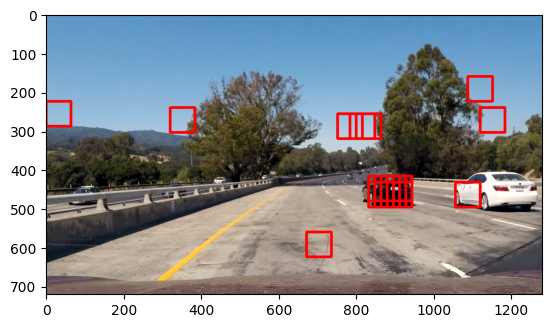

In [37]:
import pickle
# Later, load the model
with open('car_detect_svm.pkl', 'rb') as f:
    loaded_svm = pickle.load(f)

# test on image without image pyramid

test1 = cv.imread('CarTrainingData/testImages/test1.jpg')
drawImg = test1.copy()

for x, y, winx, winy in slidingWindows(test1):
    window = test1[y:winy, x:winx, :]
    if window.shape != (64, 64, 3):
        continue
    window_hog_features = getHogFeatures([window])
    if loaded_svm.predict(window_hog_features) == 1 and loaded_svm.predict_proba(window_hog_features)[0][1] >= 0.9:
        print(loaded_svm.predict_proba(window_hog_features)[0][1])
        drawImg = cv.rectangle(drawImg, (x, y), (winx, winy), color=(0,0,255), thickness=5)
drawImg = cv.cvtColor(drawImg, cv.COLOR_BGR2RGB)

plt.imshow(drawImg)
plt.show()

In [23]:
# Need to make image pyramid to provide images at different scales
# scale down